In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
import glob

In [5]:
#reading the .npy files and getting into image 
path='C://Users//kyathi//Documents//Downloads//Regions//regions/'
i=1
numpy_vars = {}
for np_name in glob.glob('C://Users//kyathi//Documents//Downloads//Regions//regions//'+'*.np[yz]'):
    img = np.load(np_name)
    img_rgb = Image.fromarray(np.uint8(img[:,:,:3], mode='RGB'))
    img_rgb.save('img'+ str(i)+'.png')
    #img_rgb.show()
    i=i+1

<h2>SIFT</h2><br>
1.Matching features across different images in a common problem in computer vision. When all images are similar in nature (same scale, orientation, etc) simple corner detectors can work. But when you have images of different scales and rotations, you need to use the Scale Invariant Feature Transform (SIFT).<br><br>
2.We want features that correspond to “parts” of images, at a more holistic level than raw pixels. We want features that are not sensitive to changes in image resolution, scale, rotation, changes in illumination (eg, position of lights). The SIFT algorithm will do this.<br><br>
3.On passing an image to SIFT function of openCV, it returns us keypoints: x, y, and octave locations for all our points of interest, plus orientation. The keypoints are scale-invariant and rotation-invariant. It also generates descriptors for each keypoint not with raw intensity values, but by computing the gradient of each pixel.<br><br>
4.The number of SIFT keypoints generated is also a hyper-parameter. It can be fine-tuned depending on the computational power and memory resources available. I have set a limit of 1000 keypoints for the SIFT features generated.

In [7]:
sift_features_limit=200
def gen_sift_features(image):
    sift = cv2.xfeatures2d.SIFT_create(sift_features_limit)
    # kp is the keypoints
    #
    # desc is the SIFT descriptors, they're 128-dimensional vectors
    # that we can use for our final features
    kp, desc = sift.detectAndCompute(image, None)
    return kp, desc

“FLANN-Matcher” will return us the number of matches among the keypoints of two images. Here “Lowe’s Ratio” is another hyper-parameter that filters out the weak keypoint matches in the results of FLANN-Matcher. Ideal ratio is around 0.75. Now we sort the potential matches in non-decreasing order of count of keypoint matches.

In [8]:
# FLANN matcher
FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

In [61]:
#function that return the match_score out of 200 and i did normalization and scaled the score between 0 and 1
def matcher_count(desc_1,desc_2,k=2):
    lowe_ratio=0.7
    matches = flann.knnMatch(desc_1,desc_2,k=2)
    matches_score = 0
    for x,(m,n) in enumerate(matches):
        if m.distance < lowe_ratio*n.distance:
            matches_score += 1
    normalized = ( matches_score- 0) / (200 - 0);
    return normalized

In [53]:
#visualizing the similar matches between two images
def sift_keypoints_match(img_1,img_2):
    q_kp,q_des = gen_sift_features(img_1)
    m_kp,m_des = gen_sift_features(img_2)
    import random
    matches_old = flann.knnMatch(q_des,m_des,k=2)
    matches = random.sample(matches_old, 50)

    # Need to draw only good matches, so create a mask
    matchesMask = [[0,0] for i in range(len(matches))]

    # ratio test as per Lowe's paper
    for i,(m,n) in enumerate(matches):
        if m.distance < lowe_ratio*n.distance:
            matchesMask[i]=[1,0]

    draw_params = dict(matchColor = (0,255,0),
                       singlePointColor = (255,0,0),
                       matchesMask = matchesMask,
                       flags = 0)

    kp_img = cv2.drawMatchesKnn(img_1,q_kp,img_2,m_kp,matches,None,**draw_params)

    plt.figure(figsize=(20,10))
    plt.axis('off')
    plt.imshow(kp_img)
    plt.show()
    return 

In [9]:
#reading the images using imread of opencv2
img1 = cv2.imread('img1.png')
img2 = cv2.imread('img2.png')
img3 = cv2.imread('img3.png')
img4 = cv2.imread('img4.png')
img5 = cv2.imread('img5.png')
img6 = cv2.imread('img6.png')

In [10]:
#getting keypoints and descriptors
kp1,desc1=gen_sift_features(img1)
kp2,desc2=gen_sift_features(img2)
kp3,desc3=gen_sift_features(img3)
kp4,desc4=gen_sift_features(img4)
kp5,desc5=gen_sift_features(img5)
kp6,desc6=gen_sift_features(img6)

In [62]:
# get the match score between the two different images img4 and img6
print("Match score between the image4 and image6 is:",matcher_count(desc4,desc6))

Match score between the image4 and image6 is: 0.065


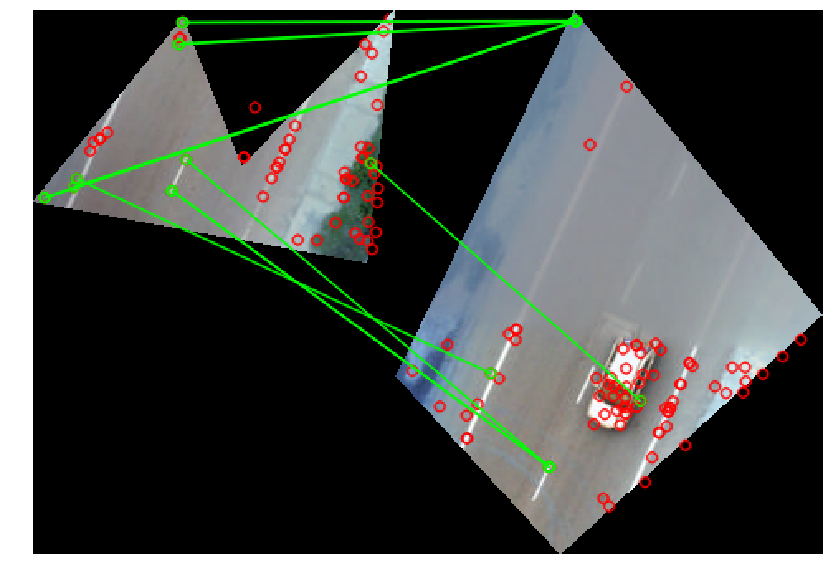

In [55]:
#visualizing the similar matches
sift_keypoints_match(img4,img6)

In [63]:
# get the match score between the two same images img4 and img4
print("Match score between the image5 and image5 is:",matcher_count(desc5,desc5))

Match score between the image5 and image5 is: 1.0


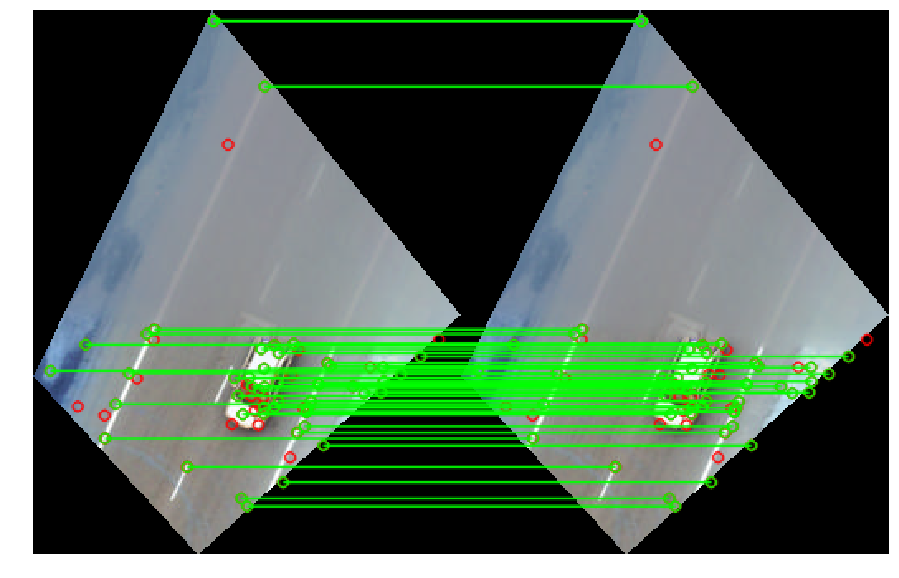

In [57]:
#visualizing the similar matches by passing two same images
sift_keypoints_match(img6,img6)

# Conclusion:

1.Score value lies between 0 and 1
2.If two images match exactly same then we will get the score of 1 else it will range between 0 and 1